<a href="https://colab.research.google.com/github/dornercr/INFO371/blob/main/INFO371_week5_featureengineering_ensemblelearning_crossvalidation_transportation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

KNN Accuracy: 0.615
Random Forest Accuracy: 0.825

- KNN can overfit if neighbors are too few.
- Random Forest reduces variance by averaging trees.
- Best models balance bias and variance to generalize well.

Random Forest KFold CV Accuracy: 0.8722515212981745
KNN LOO CV Accuracy (subset): 0.56
Random Forest StratifiedKFold CV Accuracy: 0.8611955613888558
Best Parameters from Grid Search: {'max_features': 2, 'n_estimators': 150}
Final Model Accuracy after Grid Search: 0.825


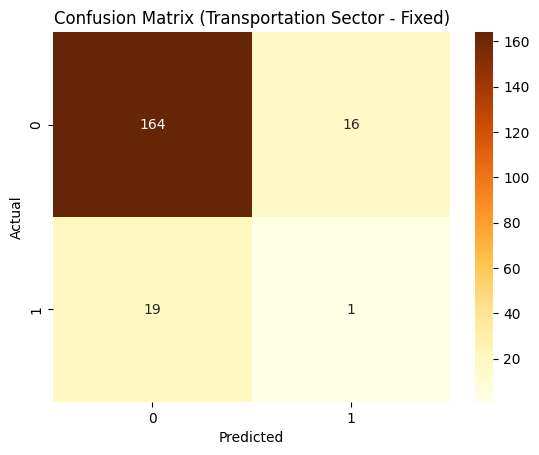


Finished: Transportation Version - Corrected with SMOTE, Feature Engineering, Model Selection, Bias-Variance, Cross Validation, Grid Search!


In [22]:
# 0. Import Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GridSearchCV, LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE  # NEW
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Generate a Realistic Transportation Dataset
np.random.seed(42)
routes = ['Route_' + str(i) for i in range(1, 11)]  # 10 bus routes
data = []

for date in pd.date_range(start='2023-01-01', periods=1000):  # More data
    route_id = np.random.choice(routes)
    scheduled_time = np.random.randint(5, 25)
    actual_time = scheduled_time + np.random.choice([-5, -2, 0, 2, 5, 10, 15], p=[0.02, 0.08, 0.5, 0.2, 0.1, 0.08, 0.02])
    day_of_week = date.dayofweek
    hour_of_day = np.random.randint(5, 23)
    rain = np.random.binomial(1, 0.25)  # 25% chance of rain
    delay = int(actual_time - scheduled_time > 5)
    data.append([date, route_id, scheduled_time, actual_time, day_of_week, hour_of_day, rain, delay])

buses = pd.DataFrame(data, columns=['Date', 'RouteID', 'ScheduledTime', 'ActualTime', 'DayOfWeek', 'HourOfDay', 'Rain', 'Delay'])
buses.sort_values('Date', inplace=True)

# 2. Create Rolling Features
buses['AvgDelayLast5'] = buses.groupby('RouteID')['Delay'].transform(lambda x: x.shift().rolling(5, min_periods=1).mean())
buses['AvgScheduledTime'] = buses.groupby('RouteID')['ScheduledTime'].transform(lambda x: x.rolling(5, min_periods=1).mean())

# 3. Feature and Label Selection
features = buses[['DayOfWeek', 'HourOfDay', 'Rain', 'AvgDelayLast5', 'AvgScheduledTime']]
labels = buses['Delay']

# Fill NaN values from rolling
features = features.fillna(0)

# 4. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# 5. SMOTE Oversampling (to balance the training set)
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

# 6. Class Weights
class_weights = dict(zip(np.unique(y_train_resampled), compute_class_weight(class_weight='balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)))

# 7. Models
# KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_resampled, y_train_resampled)
knn_preds = knn.predict(X_test)
print("KNN Accuracy:", accuracy_score(y_test, knn_preds))

# Random Forest
rf = RandomForestClassifier(n_estimators=100, max_features=2, random_state=42, class_weight=class_weights)
rf.fit(X_train_resampled, y_train_resampled)
rf_preds = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, rf_preds))

# 8. Bias-Variance Tradeoff
print("""
- KNN can overfit if neighbors are too few.
- Random Forest reduces variance by averaging trees.
- Best models balance bias and variance to generalize well.
""")

# 9. Cross-Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
rf_cv_scores = cross_val_score(rf, X_train_resampled, y_train_resampled, cv=kfold)
print("Random Forest KFold CV Accuracy:", np.mean(rf_cv_scores))

loo = LeaveOneOut()
small_features = X_train_resampled.sample(50, random_state=42)
small_labels = y_train_resampled.loc[small_features.index]
loo_scores = cross_val_score(knn, small_features, small_labels, cv=loo)
print("KNN LOO CV Accuracy (subset):", np.mean(loo_scores))

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
stratified_scores = cross_val_score(rf, X_train_resampled, y_train_resampled, cv=skfold)
print("Random Forest StratifiedKFold CV Accuracy:", np.mean(stratified_scores))

# 10. Grid Search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_features': [1, 2, 3]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42, class_weight=class_weights), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_resampled, y_train_resampled)

print("Best Parameters from Grid Search:", grid_search.best_params_)
final_model = grid_search.best_estimator_
final_preds = final_model.predict(X_test)
print("Final Model Accuracy after Grid Search:", accuracy_score(y_test, final_preds))

# 11. Confusion Matrix
cm = confusion_matrix(y_test, final_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrBr')
plt.title('Confusion Matrix (Transportation Sector - Fixed)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 12. Completion Message
print("\nFinished: Transportation Version - Corrected with SMOTE, Feature Engineering, Model Selection, Bias-Variance, Cross Validation, Grid Search!")
